In [1]:
import gymnasium as gym

import numpy as np

import random
from collections import deque
import math

import torch
import torch.nn as nn
import torch.optim as optim

c:\Users\Nicolas Ong\Documents\Data2\Python\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 SUPER'

In [ ]:
#looking at all the envs available
def list_gym_environments():
    print("num envs: " + str(len(gym.envs.registry)))
    for k, v in gym.envs.registry.items():
        print(k)

list_gym_environments()

In [ ]:
env = gym.make("LunarLander-v2", continuous=False, render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   #print(env.action_space.sample())
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)
   #print(observation)

   if terminated or truncated:
      observation, info = env.reset()
      break
env.close()

In [3]:
class ReplayBuffer():
    def __init__(self, batch_size):
        self.buffer = deque(maxlen=1000)
        self.batch_size = batch_size
    
    def add_experience(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample_batch(self):
        return random.choices(self.buffer, k=self.batch_size)


In [4]:
class QNetwork(nn.Module):
    def __init__(self, in_dim, h1_dim, h2_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x


In [5]:
class Agent():
    def __init__(self):
        self.replayBuffer = ReplayBuffer(50000)

        self.qNetwork = QNetwork(8, 16, 16, 4).to(device)
        self.targetNetwork = QNetwork(8, 16, 16, 4).to(device)
        self.targetNetwork.eval()
        self.updateTargetNet()

        self.training = True
        self.epsilon = 1
        self.gamma = 0.95
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.qNetwork.parameters(), lr=0.00025)
    
    def updateTargetNet(self):
        self.targetNetwork.load_state_dict(self.qNetwork.state_dict())
    
    def set_training(self, train):
        self.training = train
    
    def get_action(self, state, action_space):
        if (self.training and np.random.random() < self.epsilon):
            action = action_space.sample()
        else:
            with torch.no_grad():
                action = self.qNetwork(torch.tensor(np.array(state)).to(device)).max(0, keepdim=True)[1].item()
        return action
    
    def record_experience(self, state, action, reward, next_state, done):
        self.replayBuffer.add_experience(state, action, reward, next_state, done)
    
    def train(self, iteration):
        # get the batch
        batch = self.replayBuffer.sample_batch()
        states, actions, rewards, next_states, done = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(-1).to(device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(-1).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
        done = torch.tensor(np.array(done), dtype=torch.float32).unsqueeze(-1).to(device)
        
        #Calculate the targets using: r + γ * max_a' Q(s', a'; θ^-)
        next_q_values = self.targetNetwork(next_states).max(1, keepdim=True)[0].detach()
        targets = rewards + (1 - done) * self.gamma * next_q_values

        #Calculate the loss with: L(θ) = E[(Q(s, a; θ) - (r + γ * max_a' Q(s', a'; θ^-))^2]
        loss = self.loss_fn(self.qNetwork(states), targets)

        #optmize:
        self.optimizer.zero_grad()
        loss.backward()

        #update target network periodically
        if (iteration % 1000 == 0):
            self.updateTargetNet()
        
        #ε = ε_min + (ε_max - ε_min) * exp(-decay_rate * step)
        epsilon_min = 0.01
        self.epsilon = epsilon_min + (1 - epsilon_min) * math.exp(-0.001 * iteration)
    
    def save(self):
        torch.save(self.qNetwork.state_dict(), "2023-04-08 model.pth")
    
    def load(self):
        self.qNetwork.load_state_dict(torch.load("2023-04-08 model.pth"))


In [ ]:
agent = Agent()

In [10]:
env = gym.make("LunarLander-v2", continuous=False)

state, info = env.reset(seed=42)
cur_reward = 0
rewards = []
for i in range(10000):
   action = agent.get_action(state, env.action_space)
   next_state, reward, terminated, truncated, info = env.step(action)
   agent.record_experience(state, action, reward, next_state, terminated or truncated)
   cur_reward += reward

   state = next_state

   agent.train(i)

   if terminated or truncated:
      print(i, cur_reward)
      rewards.append(cur_reward)
      cur_reward = 0
      state, info = env.reset()
      #break
env.close()

c:\Users\Nicolas Ong\Documents\Data2\Python\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([50000, 1])) that is different to the input size (torch.Size([50000, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


112 -326.1451171057038
215 -318.68100815317064
337 -230.1798432457245
463 -237.02677857883404
672 -423.8059303552844
758 -585.113244322356
1019 -1207.403275111406
1118 -490.8706910874969
1203 -517.4225344187056
1475 -1493.704870995268
1590 -333.9742678655202
1640 -402.6924494625042
1802 -1493.3919880930523
1947 -610.295995896468
2158 -1804.4197835146558
2362 -1916.7489948391099
2502 -683.5582821288144
2611 -574.498567788336
2806 -2037.5494344565234
2882 -369.5675939069098
3014 -647.7768296843691
3121 -579.6926989618871
3218 -327.4922230028102
3315 -418.65554576774684
3484 -1901.9778289547276
3536 -459.0051285312743
3659 -435.81897621725005
3709 -396.03234139559294
3834 -523.9782413313874
3927 -546.926838815648
4003 -363.3252030536756
4092 -380.8417188672938
4195 -441.6235352810312
4298 -440.6818326426951
4481 -1803.5330326908181
4567 -448.8494037387895
4730 -1744.601931981212
4924 -1780.0569347861501
5032 -461.1139882241744
5119 -578.00103703518
5206 -493.95444698450115
5321 -539.53539

KeyboardInterrupt: 

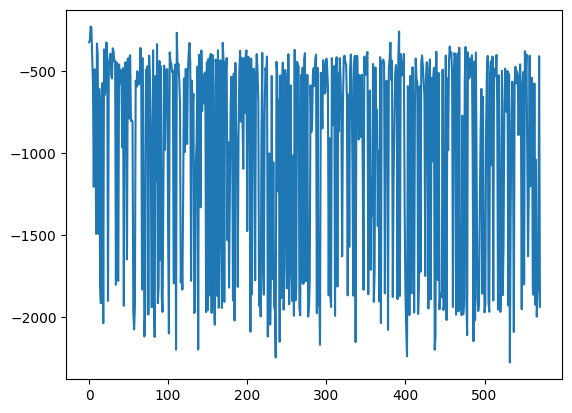

In [11]:
import matplotlib.pyplot as plt
plt.plot(rewards)